In [3]:
from matplotlib import pyplot as plt

In [4]:
# will return bandwidth in Bytes/sec.
def convBandwidth(input):
    if input[-4:] == "Mbps" : return ((10**6) * float(input[:-4]))/8
    elif input[-4:] == "MBps" : return (10**6) * float(input[:-4])
    elif input[-3:] == "Bps" : return float(input[:-3])
    elif input[-3:] == "bps"    : return float(input[:-3])/8
    else:
        print("conversion not supported")
        return -1

# will return time in sec.
def convTime(input):
    if input[-2:] == "ms" : return (10**(-3) * float(input[:-2]))
    elif input[-1:] == "s" : return float(input[:-1])
    elif input[-3:] == "sec" : return float(input[:-3])
    else:
        print("conversion not supported")
        return -1

# values_dict is a time series data dictionary
def plotvstime(values_dict, xlabel, ylabel, title):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    plt.plot(values_dict.keys(), values_dict.values())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    

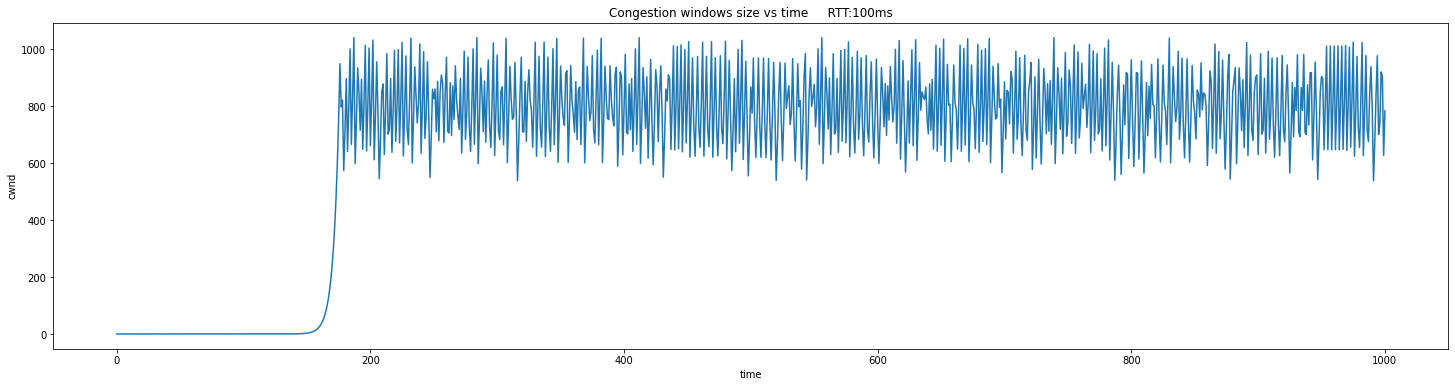

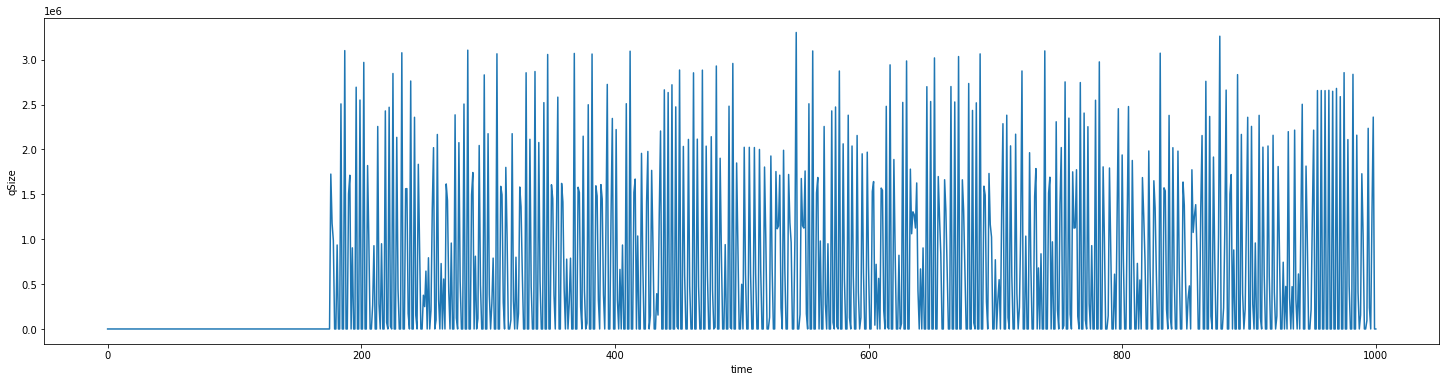

In [15]:
# Discrete time interval 
deltaTime_str = "1sec"
deltaTime = convTime(deltaTime_str)

class queueObj:
    maxSizeBytes = 0
    currSizeBytes = 0.00000000001 
    
    # will get updated after constructor call
    btlnkBandwidth = 1 
    queueingDelay = currSizeBytes/btlnkBandwidth
    
    def __init__(self, maxSizeBytes, btlnkBandwidth):
        self.maxSizeBytes = maxSizeBytes
        self.btlnkBandwidth = btlnkBandwidth
        
            
    def updateSize(self, cwndSizeBytes, RTT):
        self.currSizeBytes = self.currSizeBytes + deltaTime*(cwndSizeBytes/RTT - self.btlnkBandwidth)
        if self.currSizeBytes < 0 : self.currSizeBytes = 0
        
        self.queueingDelay = self.currSizeBytes/self.btlnkBandwidth

    
# Ti : RTT min for a flow i 
# D : Queueing delay for all flows    
def MIMD(qObj, Ti, D):
    # if the queue is 1/3rd( subject to change) filled, then bandwidth is underestimated i.e. pacing controlled
    if ( qObj.currSizeBytes < qObj.maxSizeBytes/3 ): return (1.25 * Ti)/(Ti + D)
    # otherwise congestion window controlled
    else: return (2 * Ti)/(Ti + D)
    


def Simul():
    starttime = 0
    endtime = 1000
    
    
    pktsize = 1500
    queueL = "2084p"
    queueSizeBytes = pktsize*int(queueL[:-1])
    
    btlnkBandwidth_str = "100Mbps"
    btlnkBandwidth = convBandwidth(btlnkBandwidth_str)
    
    # Creating a queue for the bottleneck link
    qobj = queueObj(queueSizeBytes, btlnkBandwidth)
    
    # We will decide the RTT
    RTT_str = "100ms"
    RTT = convTime(RTT_str)
        
    cwndSize = 0.00000000001
    
    cwndSizeStore = {}
    qSizeStore = {}
    currtime = starttime
    while currtime <= endtime:
        
        # simulation starts here
        cwndSize = cwndSize * MIMD(qobj, RTT, qobj.queueingDelay)       
        
        qobj.updateSize(cwndSize, RTT)
        
        # storing the number of packets( 1 pkt = 1500 By ) in the congestion window
        cwndSizeStore[currtime] = cwndSize/1500
        
        # storing the qsize for plotting
        qSizeStore[currtime] = qobj.currSizeBytes
        
        currtime = currtime + deltaTime
    
    plotvstime(cwndSizeStore, ylabel="cwnd", xlabel="time", title = f"Congestion windows size vs time     RTT:{RTT_str}")    
    plotvstime(qSizeStore, ylabel="qSize", xlabel="time", title = "")
    
            
Simul()

    
        